<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

En esta tarea aplicaremos el procedimiento de predicción de precios de casas desarrollado en el [libro]() en la `sección 10.14.1 California Housing`.

Usaremos el modelo de aumento de gradiente **(Gradient Boosting)** para producir un modelo predictivo a partir de un conjunto de modelos predictivos débiles **(weak)**, usando la función **ensemble.GradientBoostingRegressor** de la librería **sklearn**.

El aumento de gradiente **(Gradient Boosting)** se puede utilizar para problemas de regresión y clasificación. En esta tarea, entrenaremos un modelo de regresión para predecir demanda eléctrica usando datos de demanda de días semejantes. Obtendremos los resultados con una función de pérdida por diferencia absuluta, usaremos 500 árboles de regresión `n_estimators=500`, con un número profundidad `J=6` y una tasa de aprendizaje de `learning_rate": 0.01`.

In [351]:
# diabetes = datasets.load_diabetes()
# X, y = diabetes.data, diabetes.target

In [352]:
#df  = pd.read_csv('prostata.csv')
#X   = pd.DataFrame(df[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]).to_numpy()
#y   = pd.DataFrame(df[['lpsa']]).to_numpy()

In [353]:
#df  = pd.read_csv('demanda.csv')
#X   = pd.DataFrame(df[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']]).to_numpy()
#y   = pd.DataFrame(df[['Y']]).to_numpy()

In [354]:
df    = pd.read_csv('demanda.csv')

## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,20].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18']] ## Regresores

## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,20].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18']] ## Regresores

print(df)

     X0         X1         X2         X3         X4         X5           X6  \
0     1  8446.2546  8542.5188  8636.1652  7680.2550  7879.4424  8218.927000   
1     1  8405.4098  8562.9526  8614.5186  7640.0082  7993.4402  8098.442200   
2     1  8306.6222  8609.1252  8615.0144  7623.4334  7984.0294  8142.563000   
3     1  8376.7830  8575.4184  8528.9058  7503.8736  7890.5644  8238.174600   
4     1  8501.6664  8634.0382  8399.8990  7411.2114  7988.8982  8379.275000   
..   ..        ...        ...        ...        ...        ...          ...   
571   1  8282.7168  8573.3440  8526.8084  7751.7116  7549.2974  8365.294167   
572   1  8288.4040  8713.6944  8543.7800  7724.8552  7490.0160  8303.711600   
573   1  8261.1958  8655.5832  8507.6230  7564.1578  7611.4526  8292.295400   
574   1  8188.9102  8525.3702  8527.4594  7505.8454  7777.4772  8351.025000   
575   1  8183.5672  8556.3534  8529.7884  7487.4990  7812.5252  8406.598600   

              X7         X8         X9  ...        

In [355]:
#df1.std(numeric_only = True) 
#df1.mean(numeric_only = True)
#df1 = df1 - df1.mean(numeric_only = True)
#df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
#X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

#dft1.std(numeric_only = True) 
#dft1.mean(numeric_only = True)
#dft1 = dft1 - dft1.mean(numeric_only = True)
#dft1 = dft1 / dft1.std(numeric_only = True) 
X_test = dft1.to_numpy()   ## Predictors
#X_test = sm.add_constant(X_test)
y_test = dft2.to_numpy()   ## Outcome

In [356]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5 )

params = { "n_estimators": 500,
           "max_depth": 6,
           "min_samples_split": 5,
           "learning_rate": 0.01,
           "loss": "absolute_error",} #"squared_error", "absolute_error", "huber", "quantile"

In [357]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, reg.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 174.8712


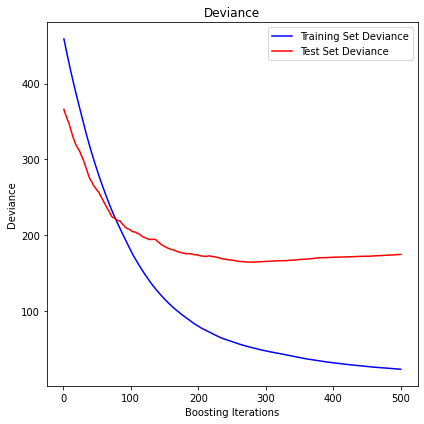

In [358]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

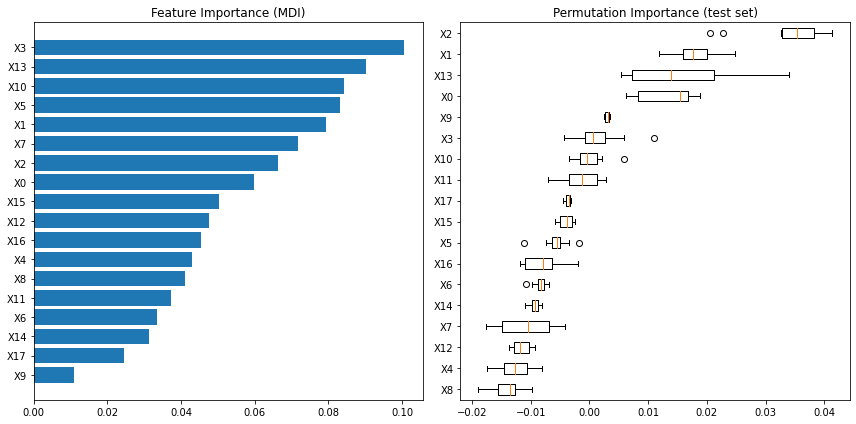

In [359]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18'])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18'])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


[Gradient Boosting regression](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html)

[sklearn.ensemble.GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
